# Import

In [1]:
#certificate verification (needed for segmentatin_models_pytorch library to work)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
#!mkdir -p /root/.cache/torch/hub/checkpoints/
#!cp /kaggle/input/se-net-pretrained-imagenet-weights/* /root/.cache/torch/hub/checkpoints/
import torch as torch 
import torch.nn as nn  
import numpy as np
from tqdm import tqdm
import os,sys,cv2
from torch.cuda.amp import autocast
import matplotlib.pyplot as plt
import albumentations as aug
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DataParallel
from glob import glob

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


  Obtaining dependency information for segmentation_models_pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.3 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

# Config

In [3]:
#percentage of augmentation
p_augment = 0.05 
class config:
    #use the SE-ResNeXt backbone 
    backbone = 'se_resnext50_32x4d'
    # prediction target size
    target_size = 1
    in_chans = 1  
    #img and input sizes
    image_size = 1024 
    input_size = 1024 

    train_batch_size = 1 
    valid_batch_size = 2

    epochs = 40
    #learning rate
    lr = 8e-5
    # fold
    valid_id = 1
    # training augmentations
    train_aug_list = [
        aug.Rotate(limit=270, p= 0.5),
        aug.RandomScale(scale_limit=(0.8,1.25),interpolation=cv2.INTER_CUBIC,p=p_augment),
        aug.RandomCrop(input_size, input_size,p=1),
        aug.RandomGamma(p=p_augment*2/3),
        aug.RandomBrightnessContrast(p=p_augment,),
        aug.GaussianBlur(p=p_augment),
        aug.MotionBlur(p=p_augment),
        aug.GridDistortion(num_steps=5, distort_limit=0.3, p=p_augment),
        ToTensorV2(transpose_mask=True),
    ]
    train_aug = aug.Compose(train_aug_list)
    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]
    valid_aug = aug.Compose(valid_aug_list)

# Model

In [4]:
#define our model, FPN 
class CustomModel(nn.Module):
    def __init__(self, config, weight=None):
        super().__init__()
        self.model = smp.FPN(encoder_name='se_resnext50_32x4d',in_channels=config.in_chans,classes=config.target_size,activation=None,)
    def forward(self, image):
        output = self.model(image)
        # output = output.squeeze(-1)
        return output[:,0]#.sigmoid()

def build_model(weight="imagenet"):
    #load_dotenv()
    #print('model_name', config.model_name)
    print('backbone', config.backbone)
    model = CustomModel(config, weight)
    return model.cuda()

# Resizing

In [5]:
def resize(img, image_size=1024):
    height, width = img.shape[:2]
    
    # if the image dimensions already equal/larger than the target size, return the original image
    if height >= image_size and width >= image_size:
        return img
    
    #padding sizes
    pad_height = (image_size - height) // 2 if height < image_size else 0
    pad_width = (image_size - width) // 2 if width < image_size else 0
    
    # add padding to the image to match target size
    img_result = np.pad(img, ((pad_height, pad_height), (pad_width, pad_width)), 'constant', constant_values=0)
    
    # for odd dimensions trim extra pixel from the bottom/right side 
    img_result = img_result[:image_size, :image_size]
    
    return img_result

# Functions

In [6]:
def min_max_normalization(x):
    """Normalize a tensor to [0, 1] across the last dimension.

    Args:
        x (torch.Tensor): Input tensor with shape (batch, f1, ...).

    Returns:
        torch.Tensor: Normalized tensor.
    """
    original_shape = x.shape  #original shape for reshaping later
    if x.ndim > 2:
        x = x.reshape(x.shape[0], -1)  # flatten the tensor while keeping the batch dimension
    
    minval = x.min(dim=-1, keepdim=True).values
    maxval = x.max(dim=-1, keepdim=True).values

    #prevent division by zero via small epsilon and normalize
    x = (x - minval) / (maxval - minval + 1e-9)
    return x.reshape(original_shape)

def norm_and_clip(x, smooth = 1e-5):
    """Standardize a tensor to have mean=0 and std=1, with clipping.

    Args:
        x (torch.Tensor): Input tensor.
        smooth (float): Smoothing term to avoid division by zero.

    Returns:
        torch.Tensor: Standardized tensor.
    """
    dim = list(range(1, x.ndim))  # dimensions over which to compute the mean and std
    mean = x.mean(dim=dim, keepdim=True)
    std = x.std(dim=dim, keepdim=True)

    return (x - mean) / (std + smooth)

#define data loader class
class Data_loader(Dataset):
     
    def __init__(self,paths,is_label):
        self.paths=paths
        self.paths.sort()
        self.is_label=is_label
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index):
         
        img = cv2.imread(self.paths[index],cv2.IMREAD_GRAYSCALE)
        
        img = resize(img , image_size = config.image_size )

        img = torch.from_numpy(img.copy())
        if self.is_label:
            img=(img!=0).to(torch.uint8)*255
        else:
            img=img.to(torch.uint8)
        return img

def load_data(paths,is_label=False):
    data_loader=Data_loader(paths,is_label)
    data_loader=DataLoader(data_loader, batch_size=16, num_workers=2)  
    data=[]
    for x in tqdm(data_loader):
        data.append(x)
    x=torch.cat(data,dim=0)
    del data
    if not is_label:
        x=(min_max_normalization(x.to(torch.float16)[None])[0]*255).to(torch.uint8)
    return x

def dice_coef(y_pred, y_true, thr=0.5, dim=(-1,-2), epsilon=0.001):
    y_pred=y_pred.sigmoid()
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean()
    return dice

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = inputs.sigmoid()   
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt is the probability of being classified as the target class
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

class Custom_Dataset(Dataset):
    def __init__(self,x,y,arg=False):
        super(Dataset,self).__init__()
        self.x=x
        self.y=y
        self.image_size=config.image_size
        self.in_chans=config.in_chans
        self.arg=arg
        if arg:
            self.transform=config.train_aug
        else: 
            self.transform=config.valid_aug

    def __len__(self) -> int:
        # calculate the total number of samples
        return sum([y.shape[0] - self.in_chans for y in self.y])
    
    def __getitem__(self,index):
        # Determine which set of x,y the current index falls into
        i = 0
        for x in self.x:
            if index > x.shape[0] - self.in_chans:
                index -= x.shape[0] - self.in_chans
                i += 1
            else:
                break
        x = self.x[i]
        y = self.y[i]
        
        # central crop calculation 
        x_index = (x.shape[1] - self.image_size) // 2
        y_index = (x.shape[2] - self.image_size) // 2
        
        # taking the relevant crop from the image and the mask
        x = x[index:index + self.in_chans, x_index:x_index + self.image_size, y_index:y_index + self.image_size]
        y = y[index + self.in_chans // 2, x_index:x_index + self.image_size, y_index:y_index + self.image_size]

        # apply transfs
        data = self.transform(image=x.numpy().transpose(1,2,0), mask=y.numpy())
        x = data['image']
        y = data['mask'] >= 127  # binarize mask based on threshold
        
        # apply augmentation
        if self.arg:
            i = np.random.randint(4)
            x = x.rot90(i, dims=(1,2))
            y = y.rot90(i, dims=(0,1))
            for i in range(3):
                if np.random.randint(2):
                    x = x.flip(dims=(i,))
                    if i >= 1:
                        y = y.flip(dims=(i-1,))
        return x, y

# Load data 

In [7]:
train_x=[]
train_y=[]

root_path="/kaggle/input/blood-vessel-segmentation/"
paths=["/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense"]
for i,path in enumerate(paths):
    if path=="/kaggle/input/blood-vessel-segmentation/train/kidney_3_dense":
        continue
    x=load_data(glob(f"{path}/images/*"),is_label=False)
    print(x.shape)
    y=load_data(glob(f"{path}/labels/*"),is_label=True)
    print(y.shape)
    train_x.append(x)
    train_y.append(y)

    #(C,H,W)
    #aug
    train_x.append(x.permute(1,2,0))
    train_y.append(y.permute(1,2,0))
    train_x.append(x.permute(2,0,1))
    train_y.append(y.permute(2,0,1))
path2="/kaggle/input/blood-vessel-segmentation/train/kidney_3_dense"
paths_y=glob(f"{path2}/labels/*")
paths_x=[x.replace("labels","images").replace("dense","sparse") for x in paths_y]

val_x=load_data(paths_x,is_label=False)
print(val_x.shape)
val_y=load_data(paths_y,is_label=True)
print(val_y.shape)

100%|██████████| 143/143 [00:45<00:00,  3.14it/s]


torch.Size([2279, 1024, 1024])


100%|██████████| 143/143 [00:24<00:00,  5.95it/s]


torch.Size([2279, 1024, 1024])


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


torch.Size([501, 1706, 1510])


100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


torch.Size([501, 1706, 1510])


# Training

In [8]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

# initialize datasets and data loaders
train_dataset = Custom_Dataset(train_x, train_y, arg=True)
train_loader = DataLoader(train_dataset, batch_size=config.train_batch_size, num_workers=2, shuffle=True, pin_memory=True)
val_dataset = Custom_Dataset([val_x], [val_y])
val_loader = DataLoader(val_dataset, batch_size=config.valid_batch_size, num_workers=2, shuffle=False, pin_memory=True)

# model, loss fn, optimizer, and scheduler setup
model = DataParallel(build_model()).cuda()
loss_function = DiceLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr)
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config.lr, steps_per_epoch=len(train_loader), epochs=config.epochs + 1, pct_start=0.1)

#training routine for an epoch
def train_epoch(loader, model, loss_function, optimizer, scaler, scheduler, is_train=True):
    if is_train:
        model.train()
    else:
        model.eval()

    losses = []
    scores = []

    progress_bar = tqdm(loader, desc="processing", leave=True)
    for x, y in progress_bar:
        x, y = x.cuda().float(), y.cuda().float()
        x = norm_and_clip(x.reshape(-1, *x.shape[2:])).reshape(x.shape)

        with autocast():
            pred = model(x)
            loss = loss_function(pred, y)

        if is_train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

        score = dice_coef(pred.detach(), y)
        losses.append(loss.item())
        scores.append(score.item())

        progress_bar.set_description(f"Loss: {np.mean(losses):.4f}, Score: {np.mean(scores):.4f}")
    
    return np.mean(losses), np.mean(scores)
#train for all epochs
def train1():
    for epoch in range(2):
        train_loss, train_score = train_epoch(train_loader, model, loss_function, optimizer, scaler, scheduler, is_train=True)
        val_loss, val_score = train_epoch(val_loader, model, loss_function, optimizer, scaler, scheduler, is_train=False)
        
        print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Train Score {train_score:.4f}, Val Loss {val_loss:.4f}, Val Score {val_score:.4f}")

    torch.save(model.module.state_dict(), f"./{config.backbone}_{epoch}_train_loss{train_loss:.2f}_train_score{train_score:.2f}_val_loss{val_loss:.2f}_val_score{val_score:.2f}.pt")

backbone se_resnext50_32x4d


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth
100%|██████████| 105M/105M [05:10<00:00, 356kB/s]


In [9]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
    
train_dataset=Custom_Dataset(train_x,train_y,arg=True)
train_dataset = DataLoader(train_dataset, batch_size=config.train_batch_size ,num_workers=2, shuffle=True, pin_memory=True)
val_dataset=Custom_Dataset([val_x],[val_y])
val_dataset = DataLoader(val_dataset, batch_size=config.valid_batch_size, num_workers=2, shuffle=False, pin_memory=True)

model=build_model()
model=DataParallel(model)

loss_fc=DiceLoss()
#use AdamW optimizer which is extension of Adam optimizer with weight decay, better for generalization 
optimizer=torch.optim.AdamW(model.parameters(),lr=config.lr)
scaler=torch.cuda.amp.GradScaler()
#one cycle learning rate schedule. Cyclical lr helps model improve accuracy in fewer steps
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config.lr,
                                                steps_per_epoch=len(train_dataset), epochs=config.epochs+1,
                                                pct_start=0.1,)
def train():
    for epoch in range(config.epochs):
        model.train()
        time=tqdm(range(len(train_dataset)))
        #init losses and scores
        losses=0
        scores=0
        #iterate through train set 
        for i,(x,y) in enumerate(train_dataset):
            x=x.cuda().to(torch.float32)
            y=y.cuda().to(torch.float32)
            #norm and clip (prevent NaN gradients)
            x=norm_and_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)
            with autocast():
                pred=model(x)
                loss=loss_fc(pred,y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
            score=dice_coef(pred.detach(),y)
            losses=(losses*i+loss.item())/(i+1)
            scores=(scores*i+score)/(i+1)
            time.set_description(f"epoch number:{epoch},loss:{losses:.4f},score:{scores:.4f},lr{optimizer.param_groups[0]['lr']:.4e}")
            time.update()
            del loss,pred
        time.close()

        model.eval()
        time=tqdm(range(len(val_dataset)))
        val_losses=0
        val_scores=0
        for i,(x,y) in enumerate(val_dataset):
            x=x.cuda().to(torch.float32)
            y=y.cuda().to(torch.float32)
            x=norm_and_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)

            with autocast():
                with torch.no_grad():
                    pred=model(x)
                    loss=loss_fc(pred,y)
            score=dice_coef(pred.detach(),y)
            val_losses=(val_losses*i+loss.item())/(i+1)
            val_scores=(val_scores*i+score)/(i+1)
            time.set_description(f"val-->loss:{val_losses:.4f},score:{val_scores:.4f}")
            time.update()

        time.close()
    torch.save(model.module.state_dict(), f"./FPN_epochs{config.epochs}_val_acc{val_scores:.2f}.pt")

    time.close()

backbone se_resnext50_32x4d


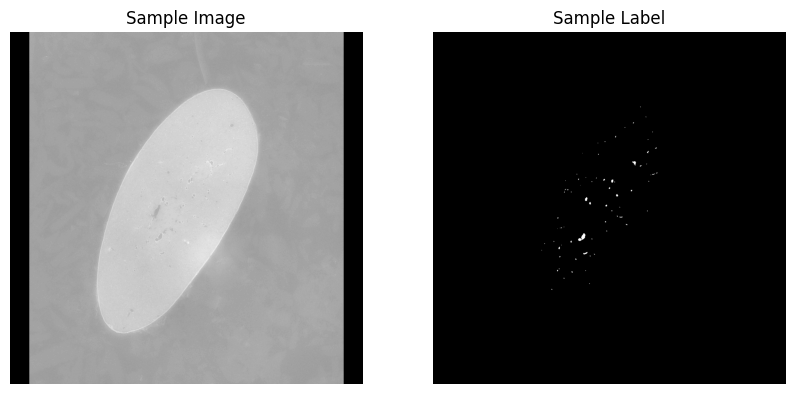

In [10]:
#visualize
import matplotlib.pyplot as plt

# Access the first element from your DataLoader
sample_image, sample_label = next(iter(train_dataset))

# Plot the image and its corresponding label
plt.figure(figsize=(10, 5))

# Plot the image
plt.subplot(1, 2, 1)
plt.imshow(sample_image.squeeze(), cmap='gray')  # Assuming the image is grayscale
plt.title('Sample Image')
plt.axis('off')

# Plot the label
plt.subplot(1, 2, 2)
plt.imshow(sample_label.squeeze(), cmap='gray')  # Assuming the label is grayscale
plt.title('Sample Label')
plt.axis('off')

plt.show()

In [11]:
train1()

Loss: 0.5576, Score: 0.4847: 100%|██████████| 250/250 [00:23<00:00, 10.56it/s]


Epoch 0: Train Loss 0.5165, Train Score 0.5364, Val Loss 0.5576, Val Score 0.4847


Loss: 0.2749, Score: 0.7490: 100%|██████████| 250/250 [00:21<00:00, 11.68it/s]


Epoch 1: Train Loss 0.2862, Train Score 0.7291, Val Loss 0.2749, Val Score 0.7490
